In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
# import multiprocessing
# from gensim.models import Word2Vec
from openTSNE import TSNE
from fdict import sfdict
from tqdm import tqdm
from sklearn.decomposition import PCA
from collections import Counter 
import re 

In [2]:
def keep_words_with_underscore(input_string):
    # Define a regular expression pattern to match words with underscores
    pattern = r'\b\w*_[\w_]*\b'

    # Use re.findall to extract words that match the pattern
    matching_words = re.findall(pattern, input_string)

    # Join the matching words to form the final string
    result = ' '.join(matching_words)

    return result


def update_co_occurrences(word_year_list,word_co_occurrences):
    # Iterate through the words in the list
    word_list = word_year_list[0]
    year = word_year_list[1]
    
    for word in word_list:
        # If the word is not already in the dictionary, add it with an empty list
        if word not in word_co_occurrences:
            word_co_occurrences[word] = {}
        
        # Add words from the list to the co-occurrence list for the current word
        for other_word in word_list:
            # if other_word != word and other_word not in word_co_occurrences[word]:
            #     word_co_occurrences[word].append(other_word)
            if other_word != word and other_word not in word_co_occurrences[word]:
                word_co_occurrences[word][other_word] = [year] 
            
            elif other_word != word and other_word in word_co_occurrences[word]:
                # word_co_occurrences[word][other_word][0] +=1
                word_co_occurrences[word][other_word].append(year)


In [3]:
ngram_abstracts = np.load("files/ngram_abstracts_repl.npy", mmap_mode="r")
concept_arr = np.unique(np.load("files/overlapping_save_concepts.npy"))
year_arr = np.load("files/year_arr.npy", mmap_mode="r")
month_arr = np.load("files/month_arr.npy", mmap_mode="r")

In [4]:
# df_ab = pd.DataFrame(data=ngram_abstracts,    # values
#                 columns=["ab"])  # 1st row as the column names
# df_ab["year"] = year_arr
# df_ab["month_arr"] = month_arr

In [5]:
# df_ab.head()

Load Concept Encoding

In [6]:
c_sfdict = sfdict(filename='files/concept_year_dict_filled.db') 
c_dict = c_sfdict.to_dict_nested()
c_sfdict.close()  # should always close a db


len_arr = []
len_new_arr = []
concept_inx_arr = []

for c in tqdm(concept_arr):
    try:
        l = len(c_dict[c])
        len_arr.append(l)
    
    
        if l > 0:
            concept_inx_arr.append(c)
            for success_inx, success_year in enumerate(np.unique(year_arr)): 
                if success_year in c_dict[c]:
                    break
        len_new_arr.append(len(c_dict[c]))
    except:
        pass
            
concept_inx_arr = np.array(concept_inx_arr)

c_reduced_dict = {key: value for key, value in c_dict.items() if key in concept_inx_arr}

100%|██████████| 8985/8985 [00:01<00:00, 8971.89it/s]


Load Co-Occur

In [7]:
ocurr_arr = []
for abstract, year in zip(ngram_abstracts, year_arr):
    temp = keep_words_with_underscore(abstract)
    if temp.count(" ")>0:
        temp = temp.split(" ") 
        ocurr_arr.append([list(filter(("_").__ne__, temp)),year])

                        
word_co_occurrences = {}

for word_list in tqdm(ocurr_arr):
    update_co_occurrences(word_list,word_co_occurrences)



100%|██████████| 143272/143272 [00:08<00:00, 16101.64it/s]


critical_point 1397
phase_diagram 1196
many_body 1021
one_dimensional 879
base_on 853
mean_field 783
first_order 752
two_dimensional 712
magnetic_field 709
critical_exponent 567
long_range 560
non_equilibrium 546
optical_lattice 533
non_hermitian 512
finite_temperature 503
finite_size 492
second_ord 482


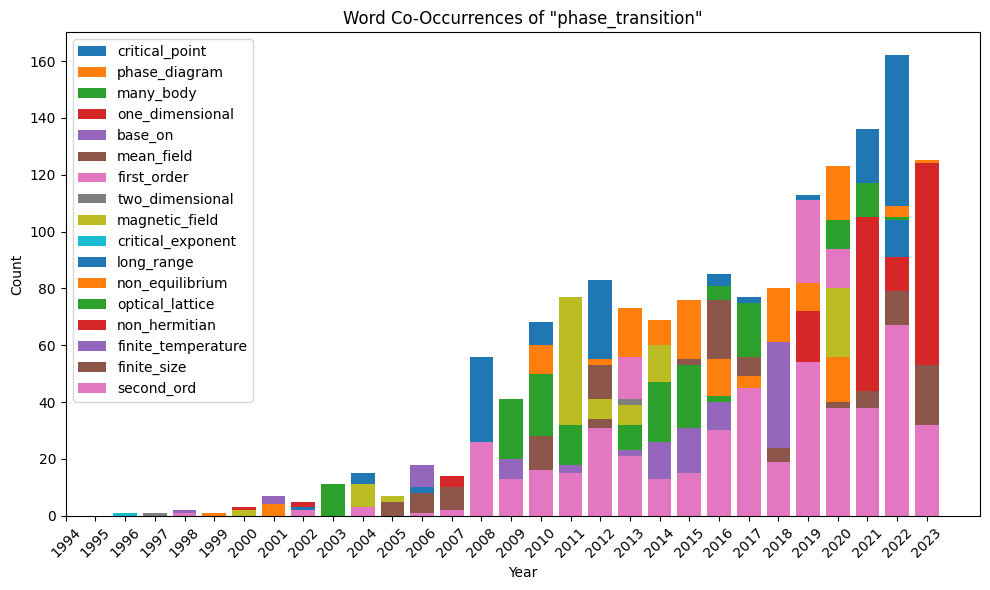

In [8]:
d = word_co_occurrences["phase_transition"]
plt.figure(figsize=(10, 6))

for cnt,k in enumerate(sorted(d, key=lambda k: len(d[k]), reverse=True)):
    print (k,len(d[k]))

    year_counts = Counter(d[k])
    unique_years = list(year_counts.keys())
    counts = list(year_counts.values())
    plt.bar(unique_years, counts,label=k)
    if cnt > 15:
        break 


plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Word Co-Occurrences of "phase_transition"')
plt.xticks(np.unique(year_arr), rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

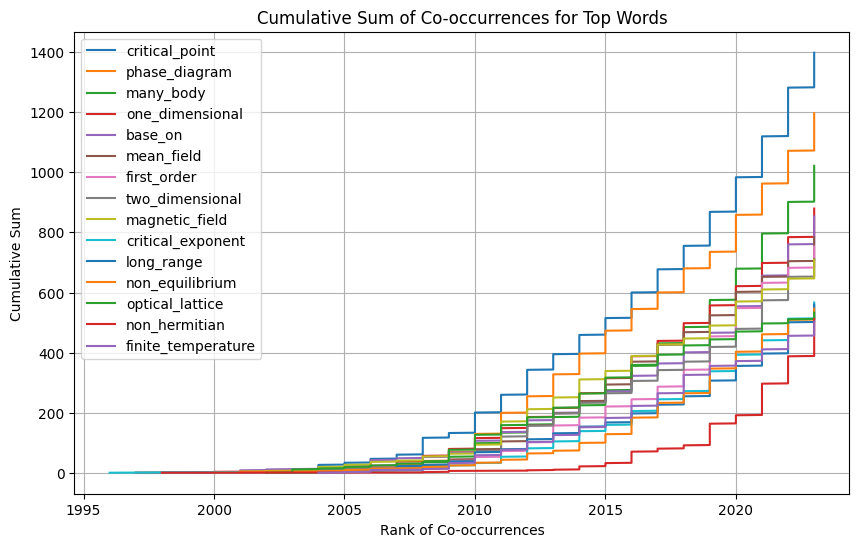

In [9]:
plt.figure(figsize=(10, 6))

# Sort the dictionary based on the length of co-occurrences
sorted_keys = sorted(d, key=lambda k: len(d[k]), reverse=True)

# Plot up to the top 15 words with the highest co-occurrence counts
for k in sorted_keys[:15]:
    plt.plot(sorted(d[k]), np.cumsum(np.ones_like(sorted(d[k]))),label=k)

# Set plot labels and title
plt.xlabel('Rank of Co-occurrences')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Co-occurrences for Top Words')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Look for concept pairs with increasing sim and no co occur 

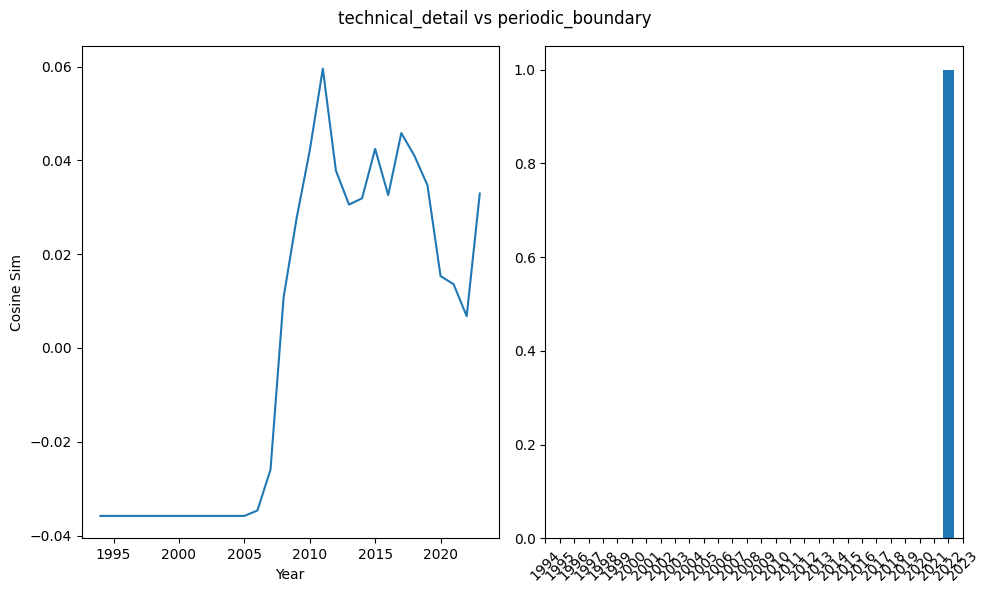

In [31]:

found = False
sim_save_arr = []
while not found:
    c1=np.random.choice(concept_inx_arr)
    c2=np.random.choice(concept_inx_arr)

    zx_d = c_dict[c1]
    su_d = c_dict[c2]

    track_vec_bell_inequality = np.array([zx_d[str(i)] for i in np.unique(year_arr)])
    track_vec_schroding_equation = np.array([su_d[str(i)] for i in np.unique(year_arr)])

    def similarity_cosine(vec1, vec2):
        cosine_similarity = np.dot(vec1, vec2)/(np.linalg.norm(vec1)* np.linalg.norm(vec2))
        return cosine_similarity

    sim_arr = [similarity_cosine(v1, v2) for (v1,v2) in zip(track_vec_bell_inequality,track_vec_schroding_equation)]

    slope, intercept = np.polyfit(np.arange(30), sim_arr, deg=1)
    
    sim_save_arr.append(sim_arr)
    if slope > 0 and c2 in word_co_occurrences[c1]:
        if len(word_co_occurrences[c1][c2])<10:
            found = True 
        
year_counts = Counter(word_co_occurrences[c1][c2])
unique_years = list(year_counts.keys())
counts = list(year_counts.values())
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[1].bar(unique_years, counts)
axs[0].plot(np.unique(year_arr),sim_arr)

axs[0].set_ylabel("Cosine Sim")
axs[0].set_xlabel("Year")

axs[1].set_xticks(np.unique(year_arr),np.unique(year_arr), rotation=45) 

fig.suptitle(c1 + " vs "+c2)
fig.tight_layout()